In [16]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import zscore
from scipy.interpolate import griddata

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/segmentation_test/regionprops/test_props.csv"
df = pd.read_csv(fpath)
df.head()

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,centroid-0,centroid-1,eccentricity,...,Cy5_max,Cy5_min,Cy5_sum,mKate_mean,mKate_max,mKate_min,mKate_sum,time,seg_channel_idx,seg_channel_name
0,1,180.0,951,730,965,746,224.0,957.816667,737.122222,0.489214,...,0.740869,0.078858,80.975314,0.161833,0.211949,0.005833,29.129897,0,2,TaGFP
1,2,153.0,454,1142,468,1158,224.0,460.810458,1149.581699,0.734127,...,0.740869,0.031991,33.508305,0.181063,0.211949,0.025833,27.702635,0,2,TaGFP
2,3,175.0,768,187,786,201,252.0,776.291429,193.051429,0.825644,...,0.160522,0.067071,20.221748,0.017200,0.025833,0.002500,3.010000,0,2,TaGFP
3,4,161.0,1977,2085,1989,2102,204.0,1981.993789,2092.900621,0.788379,...,0.740869,0.081664,82.141901,0.082304,0.211949,0.004167,13.250938,0,2,TaGFP
4,5,187.0,489,1121,505,1137,256.0,496.732620,1128.171123,0.690691,...,0.740869,0.029186,35.230816,0.172176,0.211949,0.010833,32.196906,0,2,TaGFP


In [3]:
pdf = df.groupby('time')['label'].count().reset_index()
pdf

,time,label
0,0,593
1,1,593
2,2,591
3,3,597
4,4,596
5,5,597
6,6,602
7,7,599
8,8,600
9,9,608


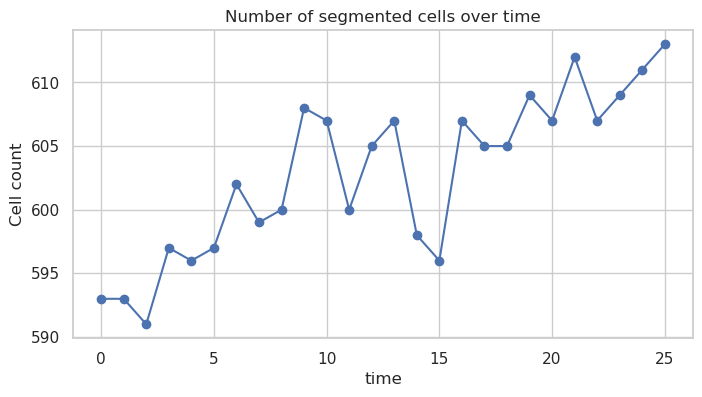

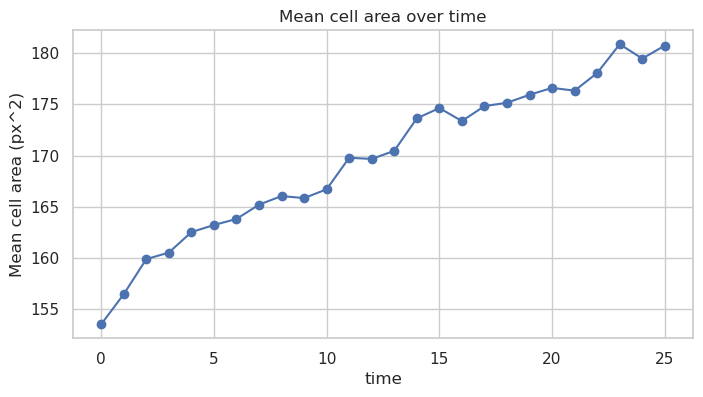

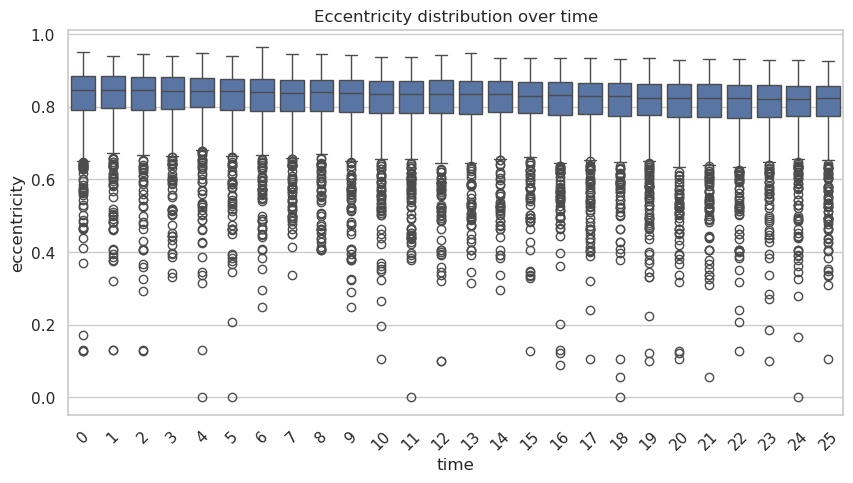

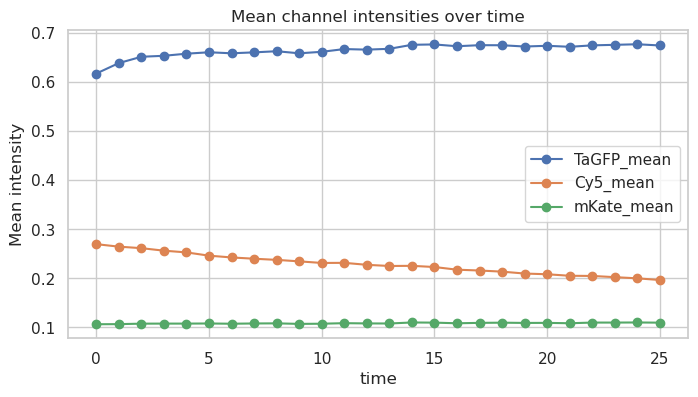

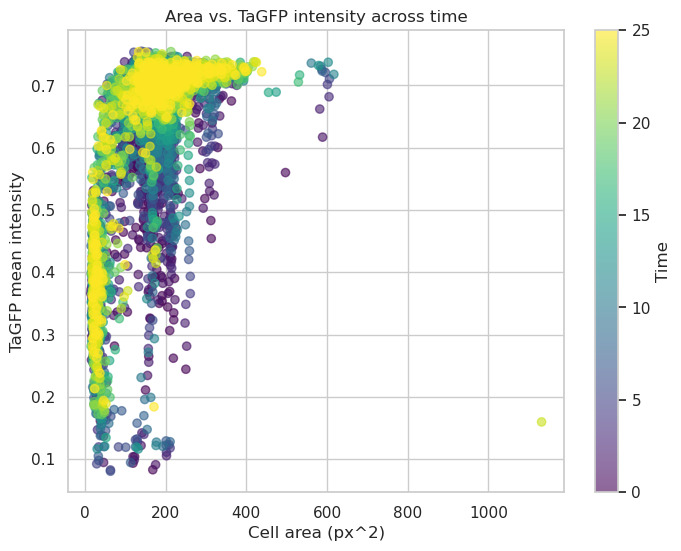

In [6]:
# Ensure numeric + sorted time
df['time'] = pd.to_numeric(df['time'], errors='coerce')
df = df.sort_values('time')

sns.set(style="whitegrid")

# 1. Number of segmented objects over time
plt.figure(figsize=(8,4))
df.groupby("time")["label"].count().plot(marker="o")
plt.ylabel("Cell count")
plt.title("Number of segmented cells over time")
plt.show()

# 2. Average cell area over time
plt.figure(figsize=(8,4))
df.groupby("time")["area"].mean().plot(marker="o")
plt.ylabel("Mean cell area (px^2)")
plt.title("Mean cell area over time")
plt.show()

# 3. Distribution of eccentricity across time
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="time", y="eccentricity")
plt.title("Eccentricity distribution over time")
plt.xticks(rotation=45)
plt.show()

# 4. Mean intensity trends per channel
plt.figure(figsize=(8,4))
for col in ["TaGFP_mean", "Cy5_mean", "mKate_mean"]:
    df.groupby("time")[col].mean().plot(marker="o", label=col)
plt.ylabel("Mean intensity")
plt.title("Mean channel intensities over time")
plt.legend()
plt.show()

# 5. Scatter: area vs. TaGFP intensity, colored by time
plt.figure(figsize=(8,6))
sc = plt.scatter(df["area"], df["TaGFP_mean"], c=df["time"], cmap="viridis", alpha=0.6)
plt.colorbar(sc, label="Time")
plt.xlabel("Cell area (px^2)")
plt.ylabel("TaGFP mean intensity")
plt.title("Area vs. TaGFP intensity across time")
plt.show()

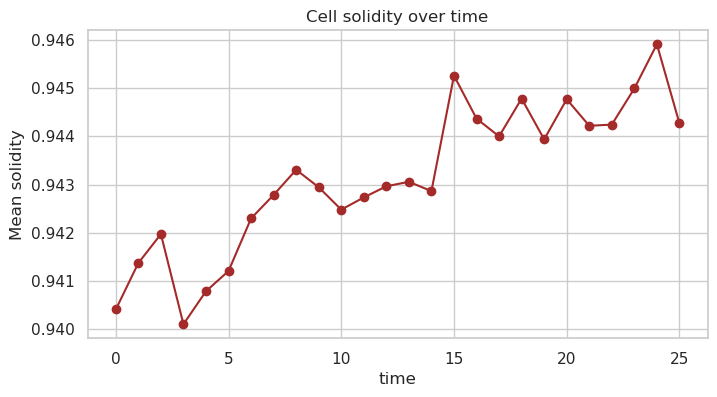

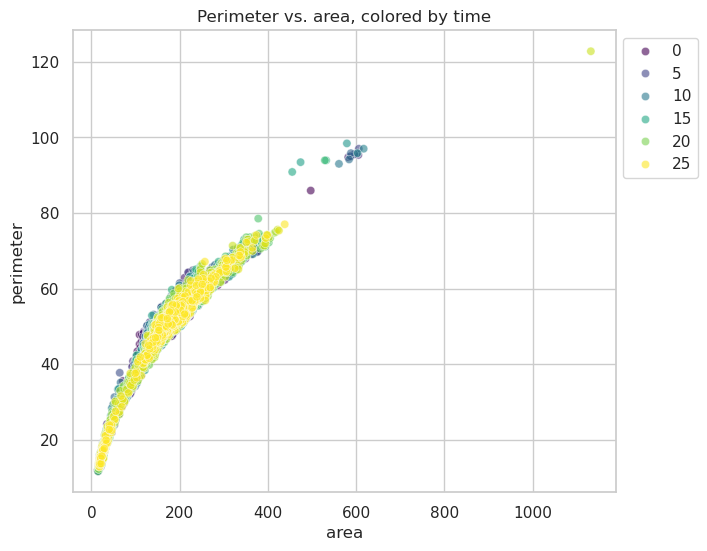

/tmp/ipykernel_2250590/2565884108.py:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="time", y="orientation", inner="quartile", scale="width")


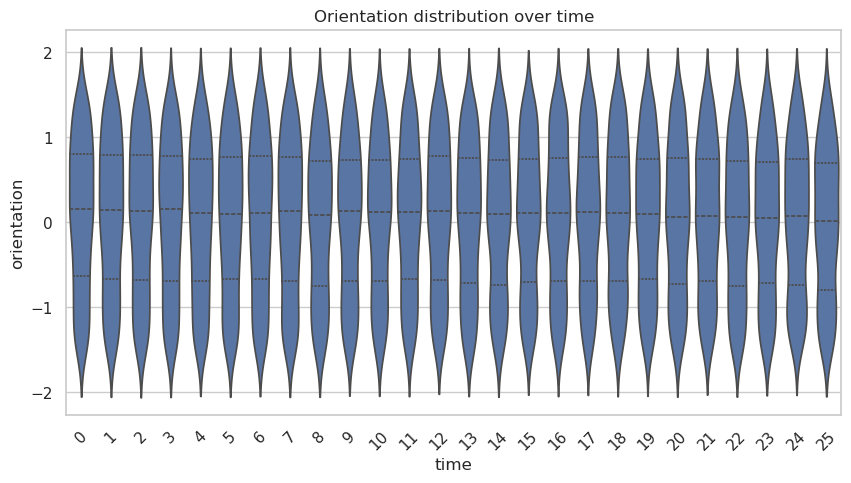

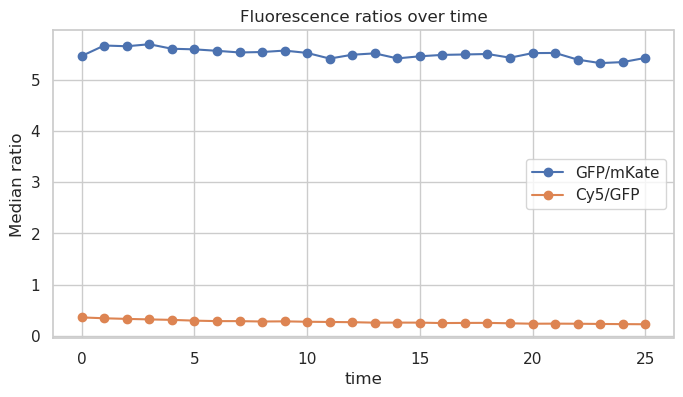

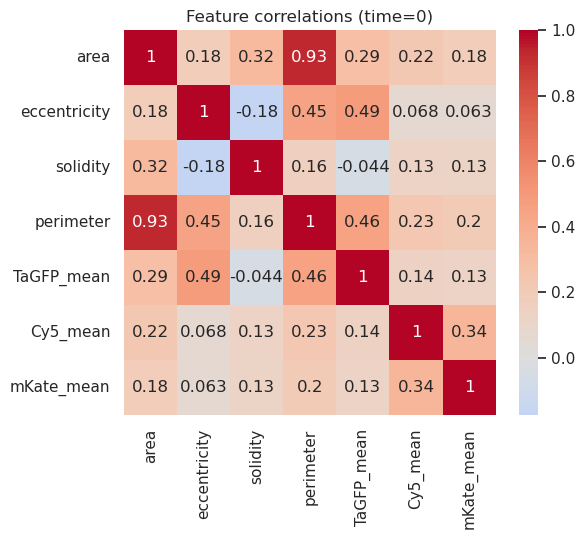

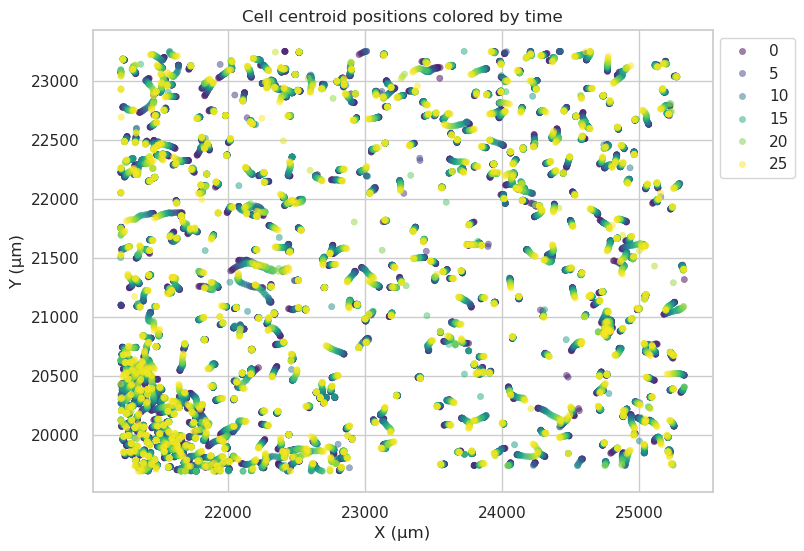

In [7]:
# 6. Solidity over time (are cells compact or fragmented?)
plt.figure(figsize=(8,4))
df.groupby("time")["solidity"].mean().plot(marker="o", color="brown")
plt.ylabel("Mean solidity")
plt.title("Cell solidity over time")
plt.show()

# 7. Perimeter vs. area (shape complexity)
plt.figure(figsize=(7,6))
sns.scatterplot(data=df, x="area", y="perimeter", hue="time", palette="viridis", alpha=0.6)
plt.title("Perimeter vs. area, colored by time")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# 8. Orientation distribution over time (shape alignment)
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x="time", y="orientation", inner="quartile", scale="width")
plt.title("Orientation distribution over time")
plt.xticks(rotation=45)
plt.show()

# 9. Fluorescence intensity ratios (GFP vs. mKate, Cy5 vs. GFP, etc.)
df["GFP_mKate_ratio"] = df["TaGFP_mean"] / (df["mKate_mean"]+1e-6)
df["Cy5_GFP_ratio"]  = df["Cy5_mean"] / (df["TaGFP_mean"]+1e-6)

plt.figure(figsize=(8,4))
df.groupby("time")["GFP_mKate_ratio"].median().plot(marker="o", label="GFP/mKate")
df.groupby("time")["Cy5_GFP_ratio"].median().plot(marker="o", label="Cy5/GFP")
plt.ylabel("Median ratio")
plt.title("Fluorescence ratios over time")
plt.legend()
plt.show()

# 10. Heatmap of feature correlations at a given time point (e.g., first frame)
subset = df[df["time"] == df["time"].min()]
corr = subset[["area","eccentricity","solidity","perimeter","TaGFP_mean","Cy5_mean","mKate_mean"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title(f"Feature correlations (time={df['time'].min()})")
plt.show()

# 11. Track centroid positions over time (drift/coverage)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="centroid_x_um", y="centroid_y_um", hue="time",
                palette="viridis", alpha=0.5, s=20, edgecolor=None)
plt.title("Cell centroid positions colored by time")
plt.xlabel("X (µm)")
plt.ylabel("Y (µm)")
plt.legend(bbox_to_anchor=(1,1))
plt.show()


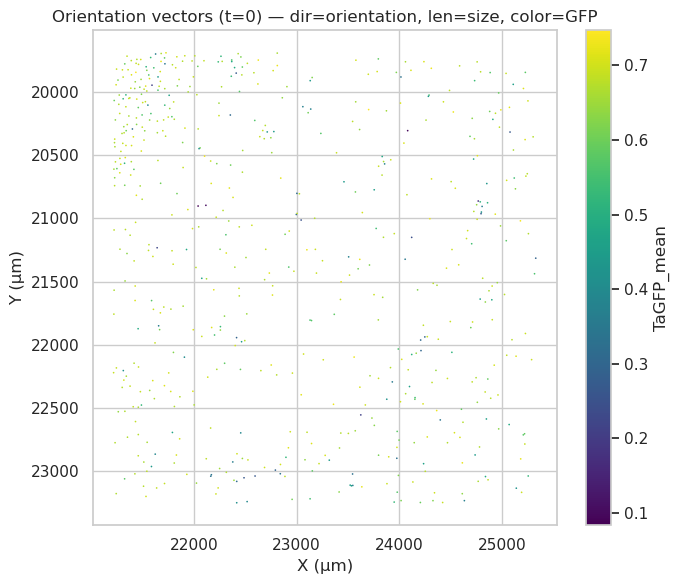

In [9]:

# pick a frame to plot
t = df["time"].min()
d = df[df["time"] == t].copy()

# direction from orientation (radians); magnitude from major axis length
theta = d["orientation"].to_numpy()
mag   = (d["major_axis_length"].to_numpy() - d["major_axis_length"].median()).clip(min=0)
mag   = mag / (mag.max() + 1e-9)  # 0..1 for clean scaling

# components
u = np.cos(theta) * mag
v = np.sin(theta) * mag

# positions in microns (fallback to px if µm missing)
X = d.get("centroid_x_um", d["centroid_x_px"]).to_numpy()
Y = d.get("centroid_y_um", d["centroid_y_px"]).to_numpy()

plt.figure(figsize=(7,6))
q = plt.quiver(X, Y, u, v, d["TaGFP_mean"], cmap="viridis", angles="xy", scale_units="xy", scale=1.0, width=0.004)
plt.colorbar(q, label="TaGFP_mean")
plt.gca().invert_yaxis()  # imaging coords
plt.title(f"Orientation vectors (t={t}) — dir=orientation, len=size, color=GFP")
plt.xlabel("X (µm)" if "centroid_x_um" in d else "X (px)")
plt.ylabel("Y (µm)" if "centroid_y_um" in d else "Y (px)")
plt.tight_layout()
plt.show()


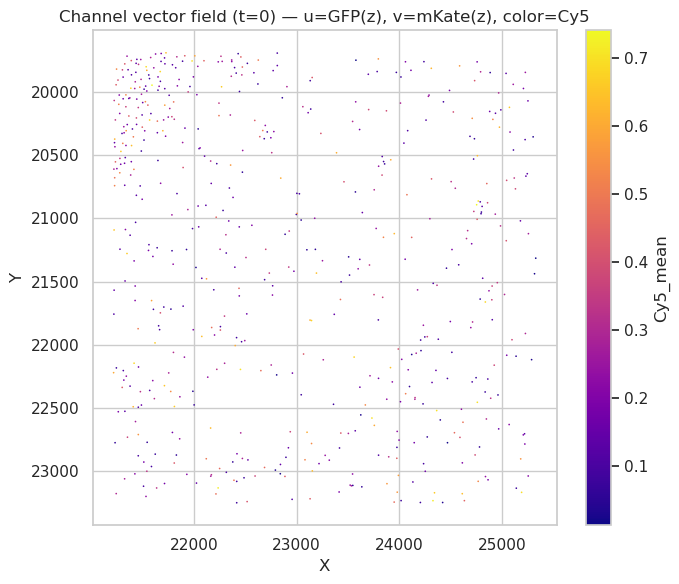

In [10]:

t = df["time"].min()
d = df[df["time"] == t].copy()

def z(x):
    x = x.to_numpy().astype(float)
    return (x - np.nanmean(x)) / (np.nanstd(x) + 1e-9)

u = z(d["TaGFP_mean"])   # x-component
v = z(d["mKate_mean"])   # y-component
c = d["Cy5_mean"].to_numpy()  # color

X = d.get("centroid_x_um", d["centroid_x_px"]).to_numpy()
Y = d.get("centroid_y_um", d["centroid_y_px"]).to_numpy()

plt.figure(figsize=(7,6))
q = plt.quiver(X, Y, u, v, c, cmap="plasma", angles="xy", scale_units="xy", scale=10, width=0.004)
plt.colorbar(q, label="Cy5_mean")
plt.gca().invert_yaxis()
plt.title(f"Channel vector field (t={t}) — u=GFP(z), v=mKate(z), color=Cy5")
plt.xlabel("X"); plt.ylabel("Y")
plt.tight_layout()
plt.show()

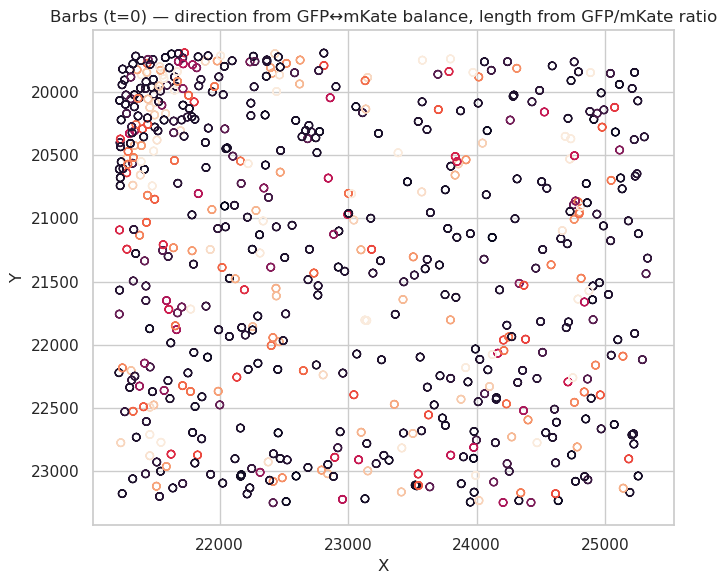

In [11]:
t = df["time"].min()
d = df[df["time"] == t].copy()

# ratios -> components
g = d["TaGFP_mean"].to_numpy().astype(float)
r = d["mKate_mean"].to_numpy().astype(float)

ratio = (g + 1e-6) / (r + 1e-6)
mag   = np.clip(ratio / np.nanpercentile(ratio, 95), 0, 1)  # robust scale 0..1
theta = np.arctan2(r, g)  # angle from channel balance

u = np.cos(theta) * mag
v = np.sin(theta) * mag

X = d.get("centroid_x_um", d["centroid_x_px"]).to_numpy()
Y = d.get("centroid_y_um", d["centroid_y_px"]).to_numpy()

plt.figure(figsize=(7,6))
plt.barbs(X, Y, u, v, mag, length=6)
plt.gca().invert_yaxis()
plt.title(f"Barbs (t={t}) — direction from GFP↔mKate balance, length from GFP/mKate ratio")
plt.xlabel("X"); plt.ylabel("Y")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2250590/501579390.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tracks = df.groupby("label", group_keys=False).apply(_vel)


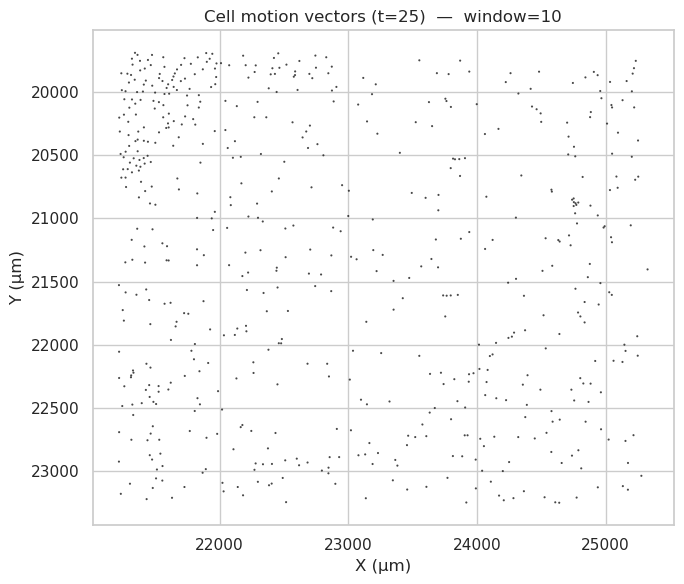

In [15]:
# --- config ---
win = 10          # smoothing window (odd, ≥3)
scale = 5.0      # quiver scale (smaller -> longer arrows)
alpha = 0.8      # arrow transparency
t_to_plot = None # e.g., set to an integer time to plot that frame only; None = last time

# --- prep ---
df = df.copy()
df["time"] = pd.to_numeric(df["time"], errors="coerce")
df = df.sort_values(["label", "time"])

# choose coordinate system
xcol = "centroid_x_um" if "centroid_x_um" in df.columns else "centroid_x_px"
ycol = "centroid_y_um" if "centroid_y_um" in df.columns else "centroid_y_px"

# --- velocities (per label) ---
def _vel(g):
    # finite differences (handle uneven dt)
    dt = g["time"].diff()
    vx = g[xcol].diff() / dt
    vy = g[ycol].diff() / dt
    # centered rolling smooth (keeps NaNs at ends minimal)
    vx_s = vx.rolling(win, center=True, min_periods=1).mean()
    vy_s = vy.rolling(win, center=True, min_periods=1).mean()
    out = g.copy()
    out["vx"] = vx_s
    out["vy"] = vy_s
    return out

tracks = df.groupby("label", group_keys=False).apply(_vel)

# drop rows without velocity (first observation per track)
tracks = tracks.dropna(subset=["vx", "vy"])

# pick a time slice
if t_to_plot is None:
    t_sel = tracks["time"].max()
else:
    t_sel = t_to_plot

D = tracks.loc[tracks["time"] == t_sel, [xcol, ycol, "vx", "vy", "label"]].copy()

# optional: normalize very large vectors (robust clip)
mag = np.hypot(D["vx"], D["vy"]).to_numpy()
q99 = np.nanpercentile(mag, 99) if len(mag) else 1.0
sf = max(q99, 1e-6)
D["vx"] = D["vx"] / sf
D["vy"] = D["vy"] / sf

# --- plot quiver (weather-style motion field) ---
plt.figure(figsize=(7, 6))
q = plt.quiver(
    D[xcol].to_numpy(), D[ycol].to_numpy(),
    D["vx"].to_numpy(), D["vy"].to_numpy(),
    angles="xy", scale_units="xy", scale=1/scale, alpha=alpha, width=0.004
)
plt.gca().invert_yaxis()  # imaging coordinates
plt.xlabel("X (µm)" if "um" in xcol else "X (px)")
plt.ylabel("Y (µm)" if "um" in ycol else "Y (px)")
plt.title(f"Cell motion vectors (t={t_sel})  —  window={win}")
plt.tight_layout()
plt.show()

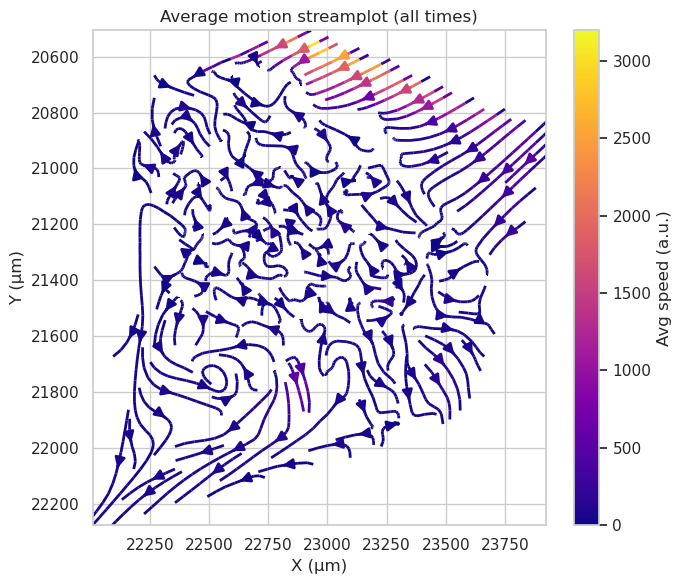

In [18]:
# choose coordinate system
xcol = "centroid_x_um" if "centroid_x_um" in df.columns else "centroid_x_px"
ycol = "centroid_y_um" if "centroid_y_um" in df.columns else "centroid_y_px"

# ensure sorted
df = df.sort_values(["label", "time"])

# compute displacements per label
df["vx"] = df.groupby("label")[xcol].diff()
df["vy"] = df.groupby("label")[ycol].diff()

# average velocity over time per cell
avg = df.groupby("label")[[xcol, ycol, "vx", "vy"]].mean().dropna()

X, Y, U, V = avg[xcol].to_numpy(), avg[ycol].to_numpy(), avg["vx"].to_numpy(), avg["vy"].to_numpy()

# --- interpolate onto a grid ---
nx, ny = 60, 60
xi = np.linspace(X.min(), X.max(), nx)
yi = np.linspace(Y.min(), Y.max(), ny)
XI, YI = np.meshgrid(xi, yi)

Ui = griddata((X, Y), U, (XI, YI), method="linear", fill_value=0)
Vi = griddata((X, Y), V, (XI, YI), method="linear", fill_value=0)

speed = np.hypot(Ui, Vi)

# --- streamplot ---
plt.figure(figsize=(7,6))
strm = plt.streamplot(
    XI, YI, Ui, Vi,
    color=speed, cmap="plasma", linewidth=2, density=1.5, arrowsize=1.5
)
plt.colorbar(strm.lines, label="Avg speed (a.u.)")
plt.gca().invert_yaxis()
plt.title("Average motion streamplot (all times)")
plt.xlabel("X (µm)" if "um" in xcol else "X (px)")
plt.ylabel("Y (µm)" if "um" in ycol else "Y (px)")
plt.tight_layout()
plt.show()